In [1]:
%%capture

!pip install unsloth
!pip install --force-reinstall --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git "transformers>=4.53.0"

In [2]:
from unsloth import tokenizer_utils
def do_nothing(*args, **kwargs):
    pass
tokenizer_utils.fix_untrained_tokens = do_nothing

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


2025-07-08 05:51:45.056282: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751953905.266261      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751953905.331212      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🦥 Unsloth Zoo will now patch everything to make training faster!


In [3]:
import torch
major_version, minor_version = torch.cuda.get_device_capability()
print(f"Major: {major_version}, Minor: {minor_version}")
from datasets import load_dataset
import datasets
from trl import SFTTrainer
import pandas as pd
import numpy as np
import os
import pandas as pd
import numpy as np
from unsloth import FastLanguageModel
from trl import SFTTrainer
from transformers import TrainingArguments, Trainer
from typing import Tuple
import warnings
from typing import Any, Dict, List, Union
from transformers import DataCollatorForLanguageModeling, AutoTokenizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Major: 6, Minor: 0


In [4]:
NUM_CLASSES = 2

max_seq_length = 2048
dtype = None

model_name = "sail/Sailor2-8B"; load_in_4bit = True
# model_name = "/kaggle/input/finetuned-sailor2/transformers/indonesian-telecom-scam/1/final_version"; load_in_4bit = True

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_name,
    load_in_4bit = load_in_4bit,
    max_seq_length = max_seq_length,
    dtype = dtype,
)

==((====))==  Unsloth 2025.7.1: Fast Qwen2 patching. Transformers: 4.53.1.
   \\   /|    Tesla P100-PCIE-16GB. Num GPUs = 1. Max memory: 15.888 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 6.0. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/5.61G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.59G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.80G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

sail/Sailor2-8B does not have a padding token! Will use pad_token = <|vision_pad|>.


In [5]:
number_token_ids = []
for i in range(0, NUM_CLASSES+1):
    number_token_ids.append(tokenizer.encode(str(i), add_special_tokens=False)[0])
par = torch.nn.Parameter(model.lm_head.weight[number_token_ids, :])

old_shape = model.lm_head.weight.shape
old_size = old_shape[0]
print(par.shape)
print(old_shape)

model.lm_head.weight = par

reverse_map = {value: idx for idx, value in enumerate(number_token_ids)} # will be used later to convert an idx from the old tokenizer to the new lm_head
reverse_map

torch.Size([3, 3584])
torch.Size([151936, 3584])


{15: 0, 16: 1, 17: 2}

In [6]:
from peft import LoftQConfig

model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = [
        "lm_head",
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj", "all-linear"],
    lora_alpha = 32,
    lora_dropout = 0.1,
    bias = "none",    
    use_gradient_checkpointing = "unsloth",
    random_state = 12,
    use_rslora = True,
)
print("trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.1.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.


Unsloth: You added custom modules, but Unsloth hasn't optimized for this.
Beware - your finetuning might be noticeably slower!
Unsloth: Offloading output_embeddings to disk to save VRAM


Unsloth 2025.7.1 patched 32 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


Unsloth: Training lm_head in mixed precision to save VRAM
trainable parameters: 46148096


In [7]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Set the input directory based on the environment
kaggle = os.getcwd() == "/kaggle/working"
input_dir = "/kaggle/input/audiodatasetindonesia/" if kaggle else "data/"

# Load the dataset
data = pd.read_csv(os.path.join(input_dir, "dataset_input.csv"))

# Preprocess the data
data = data.rename(columns={"text": "label", "transcription": "text"})
if "audio" in data.columns:
    data = data.drop("audio", axis=1)

# Create a mapping for the old labels to the new labels
label_mapping = {0: 1, 1: 2}
data['label'] = data['label'].map(label_mapping)

# Separate features (X) and target (y)
features = data.drop('label', axis=1)
labels = data['label']

# --- Step 1: Split data into training (80%) and a temporary set (20%) ---
X_train, X_temp, y_train, y_temp = train_test_split(
    features, labels, test_size=0.2, random_state=42, stratify=labels
)

# --- Step 2: Split the temporary set (20%) into validation (10%) and test (10%) ---
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# --- Combine features and labels back into final DataFrames ---
train_df = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
val_df = pd.concat([X_val, y_val], axis=1).reset_index(drop=True)
test_df = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

# --- Print the results of the new splits ---
print("--- Training Set (80%) ---")
print(f"Total length: {len(train_df)}")
print("Class distribution:")
print(train_df['label'].value_counts())
print("\n" + "="*25 + "\n")

print("--- Validation Set (10%) ---")
print(f"Total length: {len(val_df)}")
print("Class distribution:")
print(val_df['label'].value_counts())
print("\n" + "="*25 + "\n")

print("--- Test Set (10%) ---")
print(f"Total length: {len(test_df)}")
print("Class distribution:")
print(test_df['label'].value_counts())

--- Training Set (80%) ---
Total length: 827
Class distribution:
label
2    414
1    413
Name: count, dtype: int64


--- Validation Set (10%) ---
Total length: 103
Class distribution:
label
1    52
2    51
Name: count, dtype: int64


--- Test Set (10%) ---
Total length: 104
Class distribution:
label
1    52
2    52
Name: count, dtype: int64


In [8]:
print(train_df)

                                                  text  label
0    Halo, 121? Selamat pagi, dengan layanan pelang...      1
1    Selamat siang, dengan Ibu Siti? Iya, ini saya....      2
2    Halo, Bu/Mas. Ini dari divisi anti-fraud bank ...      2
3    Selamat pagi, ini resepsionis dari salon XYZ. ...      1
4    Selamat siang, ini dari Unit Cyber Polri. Berb...      2
..                                                 ...    ...
822  Halo, ini toko elektronik ya? Iya, betul. Mas,...      1
823  Halo, ini dengan toko kamera? Iya. Mas, saya m...      1
824  Pak, ini jasa pasang pompa air? Iya. Kalau pas...      1
825  Halo, Pak. Saya driver Maxim. Iya, Mas. Mau an...      1
826  Selamat siang, saya Brigadir Andi dari Direkto...      2

[827 rows x 2 columns]


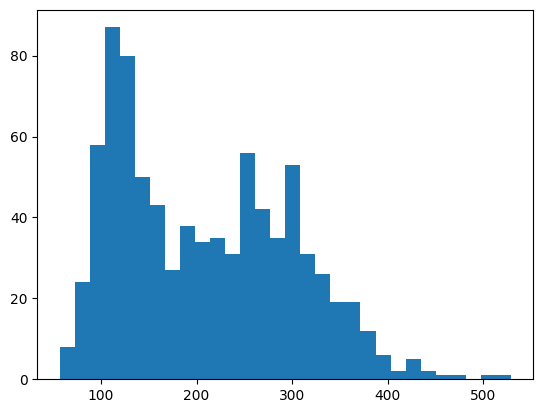

In [9]:
token_counts = [len(tokenizer.encode(x)) for x in train_df.text]
# plot the token counts
a = plt.hist(token_counts, bins=30)

In [10]:
prompt = """Berdasarkan  percakapan 2 orang melalui telepon berikut, klasifikasikan label yang 1 untuk percakapan biasa dan 2 untuk penipuan telekom:
{}
Klasifikasi yang benar adalah: kelas {}"""

def formatting_prompts_func(dataset_):
    texts = []
    for i in range(len(dataset_['text'])):
        text_ = dataset_['text'].iloc[i]
        label_ = dataset_['label'].iloc[i]
        text = prompt.format(text_, label_)
        texts.append(text)
    return texts

train_df['text'] = formatting_prompts_func(train_df)
train_dataset = datasets.Dataset.from_pandas(train_df,preserve_index=False)
val_dataset = datasets.Dataset.from_pandas(val_df,preserve_index=False)

In [11]:
print(train_dataset[0]["text"])

Berdasarkan  percakapan 2 orang melalui telepon berikut, klasifikasikan label yang 1 untuk percakapan biasa dan 2 untuk penipuan telekom:
Halo, 121? Selamat pagi, dengan layanan pelanggan Kereta Api Indonesia. Pagi. Mau tanya, kereta dari Jatinegara ke Cirebon yang paling pagi jam berapa ya? Untuk tujuan Cirebon, paling pagi ada Cirebon Ekspres jam 15, Pak. Jam 15 ya. Itu kelas ekonomi atau eksekutif? Ada kelas ekonomi dan eksekutif, Pak, dalam satu rangkaian. Oke, baik. Cukup. Terima kasih. Sama-sama. Selamat beraktivitas kembali.
Klasifikasi yang benar adalah: kelas 1


In [12]:
class DataCollatorForLastTokenLM(DataCollatorForLanguageModeling):
    def __init__(
        self,
        *args,
        mlm: bool = False,
        ignore_index: int = -100,
        **kwargs,
    ):
        super().__init__(*args, mlm=mlm, **kwargs)
        self.ignore_index = ignore_index

    def torch_call(self, examples: List[Union[List[int], Any, Dict[str, Any]]]) -> Dict[str, Any]:
        batch = super().torch_call(examples)

        for i in range(len(examples)):
            last_token_idx = (batch["labels"][i] != self.ignore_index).nonzero()[-1].item()
            batch["labels"][i, :last_token_idx] = self.ignore_index
            batch["labels"][i, last_token_idx] = reverse_map[ batch["labels"][i, last_token_idx].item() ]

        return batch
collator = DataCollatorForLastTokenLM(tokenizer=tokenizer)

<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

In [13]:
lr = 2e-5

epochs=1
schedule="constant"

batch_size = 8

In [14]:
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    eval_dataset=val_dataset,
    max_seq_length = max_seq_length,
    dataset_num_proc = 1,
    packing = False, 
    args = TrainingArguments(
        per_device_train_batch_size = batch_size,
        gradient_accumulation_steps = 1,
        warmup_steps = 0,
        learning_rate = lr,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        weight_decay = 0.01,
        lr_scheduler_type = "constant",
        seed = 3407,
        output_dir = "outputs",
        num_train_epochs = epochs,
        report_to = "none",
        group_by_length = True,
        gradient_checkpointing=True,
        gradient_checkpointing_kwargs={'use_reentrant':False},
        label_names=["label"]
    ),
    data_collator=collator,
    dataset_text_field="text",
)

Unsloth: Tokenizing ["text"]:   0%|          | 0/827 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"]:   0%|          | 0/103 [00:00<?, ? examples/s]

In [15]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla P100-PCIE-16GB. Max memory = 15.888 GB.
7.34 GB of memory reserved.


In [16]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 827 | Num Epochs = 1 | Total steps = 104
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 1 x 1) = 8
 "-____-"     Trainable parameters = 46,148,096 of 8,048,550,400 (0.57% trained)


Step,Training Loss
1,1.384400
2,1.431200
3,1.284600
4,1.234600
5,1.332600
6,1.242100
7,1.268400
8,0.363400
9,0.259200
10,0.081400


In [17]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

1532.0692 seconds used for training.
25.53 minutes used for training.
Peak reserved memory = 7.959 GB.
Peak reserved memory for training = 0.619 GB.
Peak reserved memory % of max memory = 50.094 %.
Peak reserved memory for training % of max memory = 3.896 %.


In [18]:
lr = 2e-5

epochs=1
schedule="cosine"

batch_size = 8

In [19]:
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    eval_dataset=val_dataset,
    max_seq_length = max_seq_length,
    dataset_num_proc = 1,
    packing = False, 
    args = TrainingArguments(
        per_device_train_batch_size = batch_size,
        gradient_accumulation_steps = 1,
        warmup_steps = 0,
        learning_rate = lr,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        weight_decay = 0.01,
        lr_scheduler_type = "cosine",
        seed = 3407,
        output_dir = "outputs",
        num_train_epochs = epochs,
        report_to = "none",
        group_by_length = True,
        gradient_checkpointing=True,
        gradient_checkpointing_kwargs={'use_reentrant':False},
        label_names=["label"]
    ),
    data_collator=collator,
    dataset_text_field="text",
)

Unsloth: Tokenizing ["text"]:   0%|          | 0/827 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"]:   0%|          | 0/103 [00:00<?, ? examples/s]

In [20]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 827 | Num Epochs = 1 | Total steps = 104
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 1 x 1) = 8
 "-____-"     Trainable parameters = 46,148,096 of 8,048,550,400 (0.57% trained)


Step,Training Loss
1,0.000000
2,0.000000
3,0.000000
4,0.000000
5,0.000000
6,0.000000
7,0.000000
8,0.000000
9,0.000000
10,0.000000


In [21]:
# Save the current (trimmed) lm_head and bias
trimmed_lm_head = model.lm_head.weight.data.clone()
trimmed_lm_head_bias = model.lm_head.bias.data.clone() if hasattr(model.lm_head, "bias") and model.lm_head.bias is not None else torch.zeros(len(number_token_ids), device=trimmed_lm_head.device)

# Create a new lm_head with shape [old_size, hidden_dim]
hidden_dim = trimmed_lm_head.shape[1]
new_lm_head = torch.full((old_size, hidden_dim), 0, dtype=trimmed_lm_head.dtype, device=trimmed_lm_head.device)
new_lm_head_bias = torch.full((old_size,), -1000.0, dtype=trimmed_lm_head_bias.dtype, device=trimmed_lm_head_bias.device)

# Fill in the weights and bias for the allowed tokens (number_token_ids)
for new_idx, orig_token_id in enumerate(number_token_ids):
    new_lm_head[orig_token_id] = trimmed_lm_head[new_idx]
    new_lm_head_bias[orig_token_id] = trimmed_lm_head_bias[new_idx]

# Update the model's lm_head weight and bias
with torch.no_grad():
    new_lm_head_module = torch.nn.Linear(hidden_dim, old_size, bias=True, device=model.device)
    new_lm_head_module.weight.data.copy_(new_lm_head)
    new_lm_head_module.bias.data.copy_(new_lm_head_bias)
    model.lm_head.modules_to_save["default"] = new_lm_head_module

print(f"Remade lm_head: shape = {model.lm_head.weight.shape}. Allowed tokens: {number_token_ids}")

Remade lm_head: shape = torch.Size([151936, 3584]). Allowed tokens: [15, 16, 17]


In [22]:
trainer.save_model("fine-tuned-model/final_version")

Evaluating: 100%|██████████| 52/52 [01:18<00:00,  1.51s/it]


Validation accuracy: 100.00% (103/103)

--- Random samples ---

Text: Halo, ini pemesan untuk kode order 1234567. Selamat siang! Pesanan Anda sedang dalam persiapan. Diperkirakan tiba sekitar 10 menit lagi. Baiklah, terima kasih. Silakan nikmati makanannya! Jika ada per
True: 1  Pred: 1 ✅
Probs: Class 1: 0.000, Class 2: 1.000, Class 3: 0.000

Text: Halo Bu Anita, ini Rizal dari TokoOnlineXYZ. Maaf untuk kabar buruknya, stok barang pesanan Anda kosong. Oh tidak, bagaimana sekarang? Tenang, kami bisa memproses refund dengan cepat, tapi perlu verif
True: 2  Pred: 2 ✅
Probs: Class 1: 0.000, Class 2: 0.000, Class 3: 1.000

Text: Malam, Mbak. Ini Ibu kos. Malam, Bu. Cuma mau kasih tahu, besok pagi jam 9 tukang ledeng mau datang perbaiki pipa di kamar mandi umum ya. Mungkin agak berisik sedikit. Oh, oke, Bu. Tidak apa-apa. Iya,
True: 1  Pred: 1 ✅
Probs: Class 1: 0.000, Class 2: 1.000, Class 3: 0.000

Text: Siang, Bu. Ini saya yang tertarik sama kontrakan di Depok. Siang. Oh iya, Pak. Bu, mau

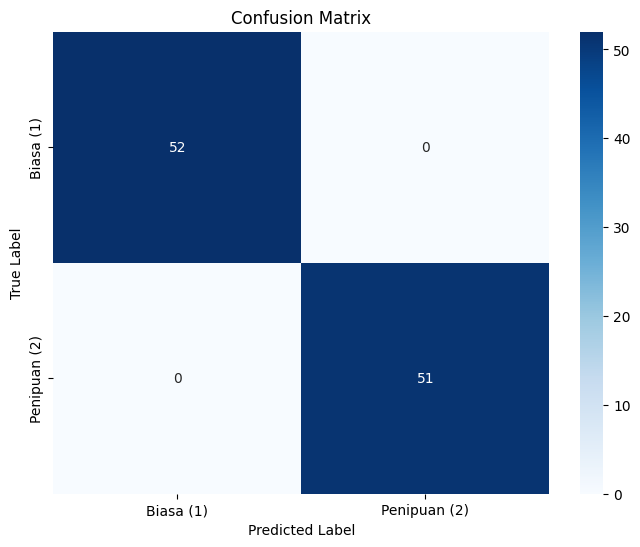

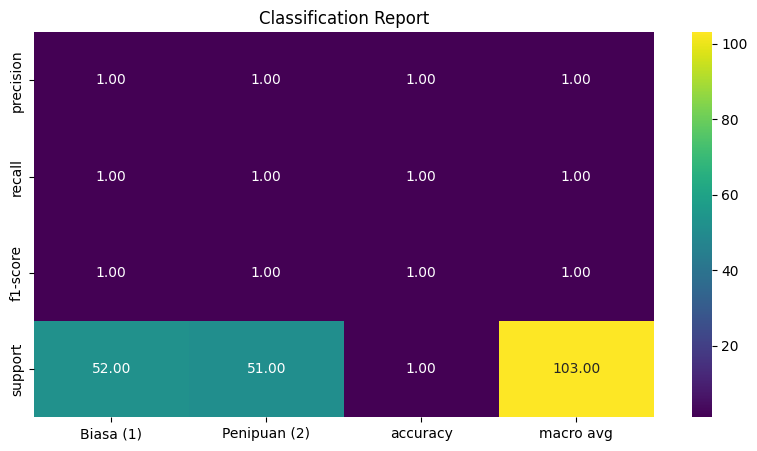


--- Classification Report ---
              precision    recall  f1-score   support

   Biasa (1)       1.00      1.00      1.00        52
Penipuan (2)       1.00      1.00      1.00        51

    accuracy                           1.00       103
   macro avg       1.00      1.00      1.00       103
weighted avg       1.00      1.00      1.00       103



In [23]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import random
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Prepare inference prompt
inference_prompt_template = """Berdasarkan percakapan 2 orang melalui telepon berikut, klasifikasikan label yang 1 untuk percakapan biasa dan 2 untuk penipuan telekom:
{}

Klasifikasi yang benar adalah: kelas """

# Sort validation set by length for efficient batching
val_df['token_length'] = val_df['text'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=False)))
val_df_sorted = val_df.sort_values(by='token_length').reset_index(drop=True)

display = 50
batch_size = 2
device = model.device
correct = 0
results = []
all_true_labels = []
all_preds = []

with torch.inference_mode():
    for i in tqdm(range(0, len(val_df_sorted), batch_size), desc="Evaluating"):
        batch = val_df_sorted.iloc[i:i+batch_size]
        prompts = [inference_prompt_template.format(text) for text in batch['text']]
        inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True, max_length=max_seq_length).to(device)
        
        logits = model(**inputs).logits
        last_idxs = inputs.attention_mask.sum(1) - 1
        last_logits = logits[torch.arange(len(batch)), last_idxs, :]
        probs_all = F.softmax(last_logits, dim=-1)
        
        # Assumes number_token_ids are for labels '1' and '2'
        probs = probs_all[:, number_token_ids] 
        
        preds = torch.argmax(probs, dim=-1).cpu().numpy()

        true_labels = batch['label'].tolist()
        correct += sum([p == t for p, t in zip(preds, true_labels)])
        
        all_true_labels.extend(true_labels)
        all_preds.extend(preds)

        # Store a few samples for display
        for j in range(len(batch)):
            results.append({
                "text": batch['text'].iloc[j][:200],
                "true": true_labels[j],
                "pred": preds[j],
                "probs": probs[j].float().cpu().numpy(),
                "ok": preds[j] == true_labels[j]
            })

accuracy = 100 * correct / len(val_df_sorted)
print(f"\nValidation accuracy: {accuracy:.2f}% ({correct}/{len(val_df_sorted)})")

print("\n--- Random samples ---")
for s in random.sample(results, min(display, len(results))):
    print(f"\nText: {s['text']}")
    print(f"True: {s['true']}  Pred: {s['pred']} {'✅' if s['ok'] else '❌'}")
    print("Probs:", ", ".join([f"Class {k+1}: {v:.3f}" for k, v in enumerate(s['probs'])]))

# ---
## Confusion Matrix
cm = confusion_matrix(all_true_labels, all_preds)
class_names = ['Biasa (1)', 'Penipuan (2)'] 

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ---
## Classification Report
report = classification_report(all_true_labels, all_preds, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Plot the classification report as an image
plt.figure(figsize=(10, 5))
sns.heatmap(report_df.iloc[:-1, :].T, annot=True, cmap='viridis', fmt='.2f')
plt.title('Classification Report')
plt.show()

# Print the text-based report to the console
print("\n--- Classification Report ---")
print(classification_report(all_true_labels, all_preds, target_names=class_names))

# Clean up
if 'token_length' in val_df:
    del val_df['token_length']

In [24]:
import torch
import torch.nn.functional as F
import time # Import the time module

def classify_text(text_input, model, tokenizer, max_seq_length):
    inference_prompt_template = """Berdasarkan percakapan 2 orang melalui telepon berikut, klasifikasikan label yang 1 untuk percakapan biasa dan 2 untuk penipuan telekom:
{}

Klasifikasi yang benar adalah: kelas """

    class_labels = [1, 2]

    try:
        number_token_ids = [tokenizer.encode("1", add_special_tokens=False)[0],
                            tokenizer.encode("2", add_special_tokens=False)[0]]
    except IndexError:
        number_token_ids = [tokenizer.convert_tokens_to_ids("1"), tokenizer.convert_tokens_to_ids("2")]

    device = model.device
    prompt = inference_prompt_template.format(text_input)

    start_time = time.monotonic()
    with torch.inference_mode():
        inputs = tokenizer(
            prompt,
            return_tensors="pt",
            truncation=True,
            max_length=max_seq_length
        ).to(device)

        logits = model(**inputs).logits
        last_token_logits = logits[0, -1, :]
        all_probs = F.softmax(last_token_logits, dim=-1)
        target_probs = all_probs[number_token_ids]
        target_probs_normalized = target_probs / target_probs.sum()
        prediction_idx = torch.argmax(target_probs_normalized).item()
        predicted_label = class_labels[prediction_idx]
    end_time = time.monotonic()
    inference_duration = end_time - start_time

    result = {
        "predicted_label": predicted_label,
        "probabilities": {
            class_labels[0]: target_probs_normalized[0].item(),
            class_labels[1]: target_probs_normalized[1].item()
        },
        "inference_time_seconds": inference_duration
    }

    return result


# --- Test with a potential scam text ---
scam_text = "Halo selamat siang, saya dari pihak Bank Sentral. Kami mendeteksi ada upaya login mencurigakan di akun Anda dari luar negeri. Untuk verifikasi keamanan, bisa tolong sebutkan nama ibu kandung dan nomor kartu ATM Anda?"

print("--- Classifying a potential scam text ---")
result_scam = classify_text(scam_text, model, tokenizer, max_seq_length)

print(f"Text: '{scam_text[:100]}...'")
print(f"Predicted Label: {result_scam['predicted_label']} {'❌ (Scam)' if result_scam['predicted_label'] == 2 else '✅ (Normal)'}")
print(f"Probabilities: {result_scam['probabilities']}")
print(f"Inference Time: {result_scam['inference_time_seconds']:.4f} seconds\n")


# --- Test with a normal conversation text ---
normal_text = "Halo, bro. Jadi ikut futsal nanti malam? Kick-off jam 8 di lapangan biasa ya. Jangan telat lagi kayak minggu lalu, haha."

print("--- Classifying a normal conversation text ---")
result_normal = classify_text(normal_text, model, tokenizer, max_seq_length)

print(f"Text: '{normal_text[:100]}...'")
print(f"Predicted Label: {result_normal['predicted_label']} {'✅ (Normal)' if result_normal['predicted_label'] == 1 else '❌ (Scam)'}")
print(f"Probabilities: {result_normal['probabilities']}")
print(f"Inference Time: {result_normal['inference_time_seconds']:.4f} seconds")

--- Classifying a potential scam text ---
Text: 'Halo selamat siang, saya dari pihak Bank Sentral. Kami mendeteksi ada upaya login mencurigakan di ak...'
Predicted Label: 2 ❌ (Scam)
Probabilities: {1: 2.9756226371802086e-09, 2: 1.0}
Inference Time: 0.5260 seconds

--- Classifying a normal conversation text ---
Text: 'Halo, bro. Jadi ikut futsal nanti malam? Kick-off jam 8 di lapangan biasa ya. Jangan telat lagi kaya...'
Predicted Label: 1 ✅ (Normal)
Probabilities: {1: 0.9999856948852539, 2: 1.4285516954259947e-05}
Inference Time: 0.4513 seconds
